<a href="https://colab.research.google.com/github/dariakrichit/samsung/blob/main/resnet18_image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [5]:
NAME='nn' #название папки на диске
drive='/content/drive/My Drive/' #название каталога
#название папок, в которых хранятся датасеты
train='train'
val='val'

In [6]:
data_transforms = {
    train: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir =drive+NAME
dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [train, val]}
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=25, shuffle=True, num_workers=0) for x in [train, val]}
dataset_size = {x: len(dataset[x]) for x in [train, val]}
class_names = dataset[train].classes

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


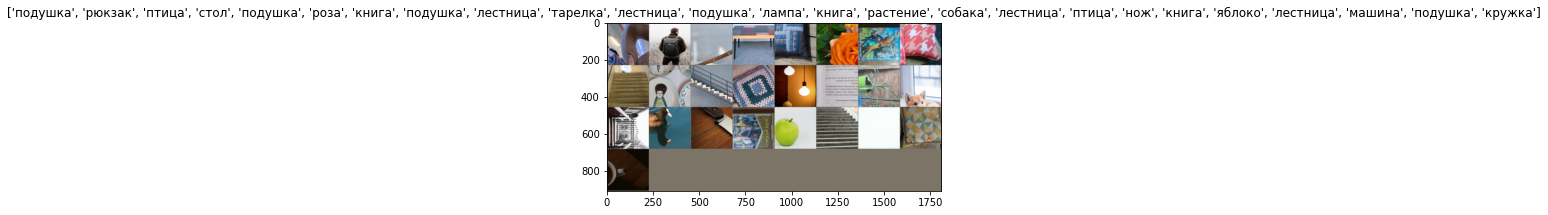

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders[train]))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []; 
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        print('Эпоха  {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in [train, val]:
            if phase == train:
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == train):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == train:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == train:
                scheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Функция потерь: {:.4f} точность: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == train:
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc)
            else:     
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc)

            if phase == val and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    model.eval()
    time_elapsed = time.time() - since
    print('Обучение завершено за {:.0f} м {:.0f} с'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Лучшая эпоха :{} значение функции потери:{:4f} точность: {:4f}'.format(best_epoch,best_loss,best_acc))

    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Фукнция потерь')
    plt.show()
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Точность')
    plt.show()

    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('предсказание: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Эпоха  0/17
----------
train Функция потерь: 2.9795 точность: 0.1470
val Функция потерь: 2.5935 точность: 0.3118

Эпоха  1/17
----------
train Функция потерь: 2.2021 точность: 0.4888
val Функция потерь: 1.7799 точность: 0.6350

Эпоха  2/17
----------
train Функция потерь: 1.6688 точность: 0.6821
val Функция потерь: 1.2719 точность: 0.7757

Эпоха  3/17
----------
train Функция потерь: 1.2865 точность: 0.7700
val Функция потерь: 1.0197 точность: 0.8289

Эпоха  4/17
----------
train Функция потерь: 1.0964 точность: 0.7907
val Функция потерь: 0.8358 точность: 0.8403

Эпоха  5/17
----------
train Функция потерь: 0.9135 точность: 0.8179
val Функция потерь: 0.6761 точность: 0.9049

Эпоха  6/17
----------
train Функция потерь: 0.8502 точность: 0.8530
val Функция потерь: 0.6382 точность: 0.8935

Эпоха  7/17
----------
train Функция потерь: 0.7061 точность: 0.8882
val Функция потерь: 0.6105 точность: 0.8935

Эпоха  8/17
----------
train Функция потерь: 0.7534 точность: 0.8674
val Функция потерь:

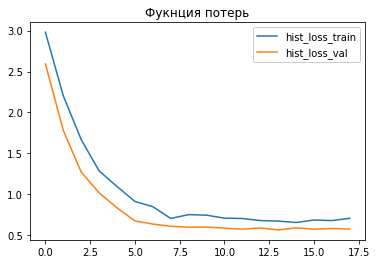

TypeError: ignored

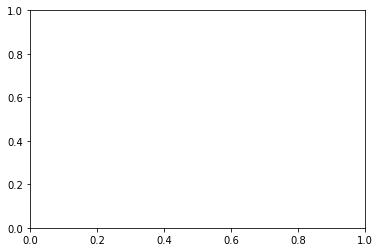

In [13]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=18)
print("--- %s секунды ---" % (time.time() - start_time))

Время инфренса батча(мс): 6.400824


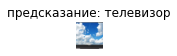

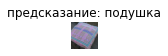

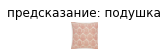

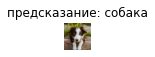

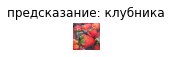

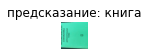

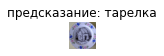

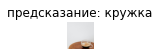

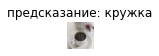

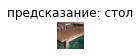

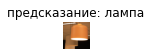

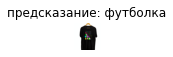

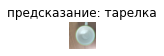

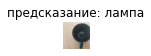

In [15]:
visualize_model(model_ft.to(device),num_images=14)

[[11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  1  1  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  1  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0

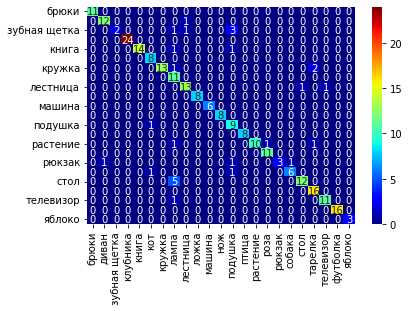

In [16]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders[val]:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='jet', annot=True)

In [17]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
script_model.save(drive+NAME+".pt")